In [38]:
#basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")

In [2]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [5]:
test_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [3]:
train_data = datasets.ImageFolder('/Users/aadityajoshi/Downloads/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/train',transform=train_transforms)

In [4]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: /Users/aadityajoshi/Downloads/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_data = datasets.ImageFolder('/Users/aadityajoshi/Downloads/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/test',transform=test_transforms)

In [7]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root location: /Users/aadityajoshi/Downloads/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [52]:
train_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_loader = DataLoader(test_data,batch_size=128,shuffle=False)
class_names = train_data.classes

In [9]:
class_names

['CAT', 'DOG']

Label: [0 1 1 0 1 0 0 0 1 0]
Class: CAT DOG DOG CAT DOG CAT CAT CAT DOG CAT


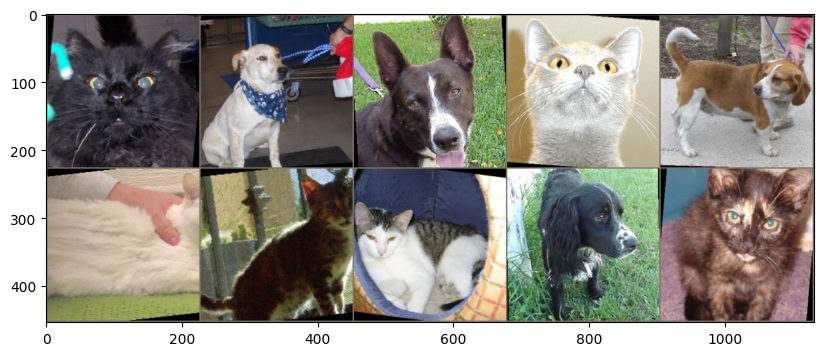

In [16]:

for images,labels in train_loader: 
    break
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [41]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    #(height,widht)
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)


In [96]:
#conv1 -> maxpool -> conv2 -> maxpool
print(f"1 : {dim_calc(3,224,224,3,1,0,4,True,2,2)}")
print(f"2 : {dim_calc(4,111,111,3,1,0,8,True,2,2)}")
print(f"3 : {dim_calc(8,54,54,3,1,0,16,True,2,2)}")
print(f"4 : {dim_calc(16,26,26,3,1,0,32,True,2,2)}")

1 : (4, 111, 111)
2 : (8, 54, 54)
3 : (16, 26, 26)
4 : (32, 12, 12)


In [97]:
16*26*26

10816

In [98]:
32*12*12

4608

In [65]:
54*16*16

13824

In [104]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(32*12*12,128)
        self.fc2 = nn.Linear(128,64)
        self.out = nn.Linear(64,2)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,32*12*12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [105]:
model = ConvNet().to(device)

In [106]:
model

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [124]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [129]:
import time 
from tqdm import tqdm
train_losses = []
start = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0
    for img,label in pbar:
        img,label = img.to(device),label.to(device)
        y_pred = model(img)
        loss = criterion(y_pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    train_losses.append(loss.item())
print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 147/147 [00:43<00:00,  3.36it/s, loss=0.0823]


Epoch 1/5, Average Loss: 0.1026


Epoch 2/5: 100%|█████████████████| 147/147 [00:43<00:00,  3.38it/s, loss=0.0351]


Epoch 2/5, Average Loss: 0.0995


Epoch 3/5: 100%|█████████████████| 147/147 [00:43<00:00,  3.39it/s, loss=0.0337]


Epoch 3/5, Average Loss: 0.0863


Epoch 4/5: 100%|█████████████████| 147/147 [00:43<00:00,  3.40it/s, loss=0.0959]


Epoch 4/5, Average Loss: 0.0839


Epoch 5/5: 100%|█████████████████| 147/147 [00:43<00:00,  3.39it/s, loss=0.0666]

Epoch 5/5, Average Loss: 0.0892
Total training time: 3.62 minutes


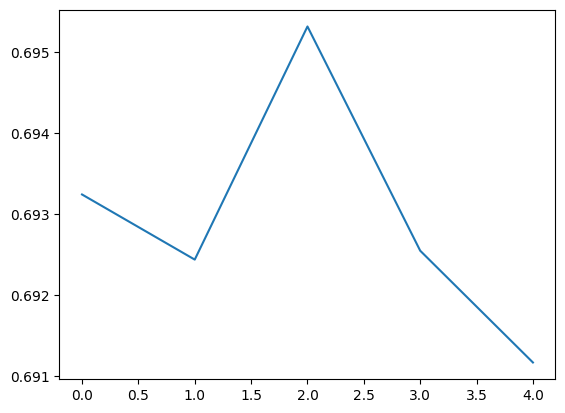

In [88]:
plt.plot(train_losses)

In [109]:
#10
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3126
           1       0.87      0.78      0.82      3125

    accuracy                           0.83      6251
   macro avg       0.83      0.83      0.83      6251
weighted avg       0.83      0.83      0.83      6251



In [112]:
#12
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3126
           1       0.91      0.71      0.80      3125

    accuracy                           0.82      6251
   macro avg       0.84      0.82      0.82      6251
weighted avg       0.84      0.82      0.82      6251



In [115]:
#14
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3126
           1       0.79      0.91      0.85      3125

    accuracy                           0.84      6251
   macro avg       0.84      0.84      0.84      6251
weighted avg       0.84      0.84      0.84      6251



In [117]:
#16
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3126
           1       0.86      0.84      0.85      3125

    accuracy                           0.85      6251
   macro avg       0.85      0.85      0.85      6251
weighted avg       0.85      0.85      0.85      6251



In [119]:
#18
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3126
           1       0.85      0.84      0.85      3125

    accuracy                           0.85      6251
   macro avg       0.85      0.85      0.85      6251
weighted avg       0.85      0.85      0.85      6251



In [122]:
#20
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3126
           1       0.85      0.86      0.85      3125

    accuracy                           0.85      6251
   macro avg       0.85      0.85      0.85      6251
weighted avg       0.85      0.85      0.85      6251



In [131]:
#25
from sklearn.metrics import classification_report 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3126
           1       0.84      0.87      0.85      3125

    accuracy                           0.85      6251
   macro avg       0.85      0.85      0.85      6251
weighted avg       0.85      0.85      0.85      6251

